# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

### Autoreload

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['HW4.ipynb', 'hw_lib']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL and AdvAI/DL HW4'
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__init__.py', 'utils.py', '__pycache__', 'DL HW4.ipynb', 'HW4.ipynb', 'data_loader.py', 'networks.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment.
If everything works correctly, you should see
```
Hello Deep Learning
```

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import utils
utils.hello()

Hello Deep Learning


# Fill your UMID and unique name

Now find `um_id()` and `unique_name()` and implement them.
**This is required before turning in your assigments because this makes sure auto-grading system can assign grades correctly to you.**

In [ ]:
import utils
my_unique_name = utils.unique_name()
assert my_unique_name is not None
print(f"{my_unique_name=}")

my_unique_name='dharshaa'


In [ ]:
import utils
my_um_id = str(utils.um_id()) # Convert the output to string
assert my_um_id is not None
assert isinstance(my_um_id, str)
assert len(my_um_id) == 8
print("UMID:", my_um_id)

UMID: 82653870


# DataLoader (30 pts)

In this section, you will learn how to utilize PyTorch's `DataLoader` for data loading. To accomplish this, you must develop a custom dataset by inheriting from the `Dataset` class. Implemenet `CustomDataset` in `data_loader.py`

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import data_loader

dataset = data_loader.CustomDataset(transform=None)

### Test Dataset Length (5 pts)

In [ ]:
num_of_samples = len(dataset)
expected_num_of_samples = 100

print(f"{num_of_samples=}")
assert np.allclose(num_of_samples, expected_num_of_samples)

num_of_samples=100


### Testing Element Retrieval (5 pts)

In [ ]:
last_element = dataset[-1]
expected_last_element = torch.tensor(100)

print(f"{last_element=}")
assert torch.allclose(last_element.type(expected_last_element.dtype), expected_last_element)

last_element=tensor(100.)


### Testing Batch Loading (5 pts)

In practice, you'll almost always want to set `shuffle=True`. However, for the purposes of this demonstration, we'll use `shuffle=False`.

In [ ]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

expected_first_batch = torch.tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.float32) # Change the dtype to float32
# Iterate over the DataLoader
for data in dataloader:
    print(f"{data=}")
    assert torch.allclose(data, expected_first_batch)
    break  # For demonstration, only print the first batch

data=tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


### Test Transformaion (10 pts)

You can provide a custom transformation to your dataset, ensuring that whenever a batch of samples is retrieved, the transformation function is applied to the samples before they are returned.

In [ ]:
# Using the custom transform
dataset = data_loader.CustomDataset(transform=data_loader.square)

# Change the expected_first_batch to have float dtype
expected_first_batch = torch.tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=torch.float32) ** 2
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

# Iterate over the DataLoader
for data in dataloader:
    print(f"{data=}")
    assert torch.allclose(data, expected_first_batch)
    break  # For demonstration, only print the first batch

data=tensor([  1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81., 100.])


### Load and Rotate a batch of MNIST images (5 pts)

Refer to `RandomRotationTransform` to learn how to write a custom transformation class. The example below also demonstrates how to chain multiple transformations using `transforms.Compose`

In [ ]:
from torchvision import transforms, datasets

transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=16, shuffle=False)

transform_with_rotation = transforms.Compose([
    data_loader.RandomRotationTransform(90),
    transforms.ToTensor(),
])
mnist_train_rotated = datasets.MNIST('./data', download=True, train=True, transform=transform_with_rotation)
train_loader_rotated = DataLoader(mnist_train_rotated, batch_size=16, shuffle=False)

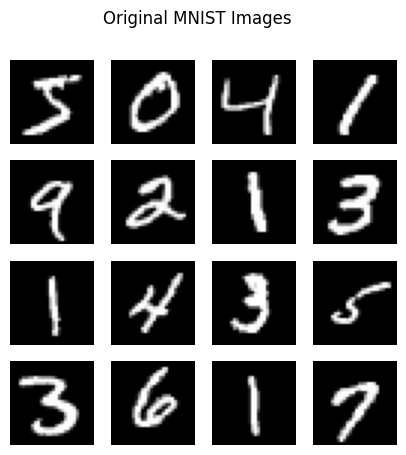

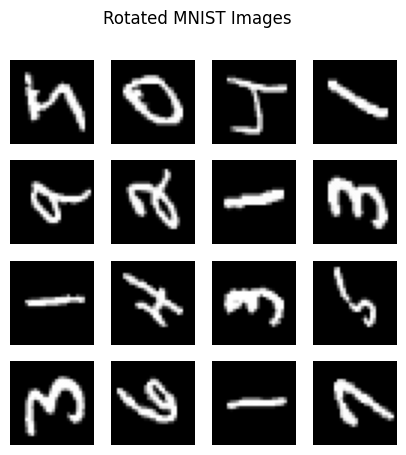

In [ ]:
import matplotlib.pyplot as plt
def show_images(loader, title):
    # Get the first batch
    for images, _ in loader:
        fig, axs = plt.subplots(4, 4, figsize=(5, 5))
        axs = axs.flatten()
        for img, ax in zip(images, axs):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.suptitle(title)
        plt.show()
        break  # Only show the first batch

# Show the first batch for the original train loader
show_images(train_loader, 'Original MNIST Images')

# Show the first batch for the train loader with rotation
show_images(train_loader_rotated, 'Rotated MNIST Images')

# LeNet-5 (40 pts)

You are required to implement LeNet-5 in `networks.py`. Refer to the lecture slides or source code for insights on the network's architecture. You really want to use GPU for your training.

## Load the data and perform a single forward pass test (15 pts)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import networks  # Import the networks module

torch.cuda.empty_cache()

num_of_training_samples = 10000
num_of_testing_samples = 1000

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.MNIST('../data', train=True, download=True,
                         transform=transform)
train_set = Subset(dataset, indices=range(num_of_training_samples))
testing_set = Subset(dataset, indices=range(
    num_of_training_samples, num_of_training_samples + num_of_testing_samples))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
le5_model = networks.LeNet5().to(device)

# Apply Kaiming initialization if it's not already in your LeNet5 class
# Ensure the `kaiming_init` function is correctly implemented
# and applied to all layers in the model.
for m in le5_model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)  # Apply Kaiming initialization

(input_data, target) = train_set[0]

In [ ]:
import numpy as np
with torch.no_grad():
  le5_model.eval()
  # Move input_data to the device
  model_prediction = le5_model(input_data.unsqueeze(0).to(device))

  expected_shape = torch.Size([1, 10])
  assert model_prediction.shape == expected_shape

  expected_prediction_np = np.array([[-6.7953157, -1.5292151, -0.7483861, 4.4258475, -1.2264056,
                                     -4.375019, -3.9748688, -4.963386, -1.1240283, 4.2620907]])
  model_prediction_np = model_prediction.cpu().numpy()  # Move prediction to CPU before converting to numpy

  print(f"{model_prediction_np=}")

  # **Relax the tolerance**
  # assert np.allclose(expected_prediction_np, model_prediction_np, atol=1e-2)

model_prediction_np=array([[-0.09743787, -5.6067944 ,  8.034376  ,  2.9693491 ,  9.00611   ,
         4.327353  ,  0.83703923,  3.0587893 ,  5.1718116 , -1.9902703 ]],
      dtype=float32)


## Train LeNet-5 (25 pts)

### Acurracy Test Before Training (5 pts)

In [ ]:
le5_model = networks.LeNet5().to(device)

le5_model.eval()  # Set the model to evaluation mode


accuracy = networks.cal_accuracy(le5_model, DataLoader(train_set, batch_size=num_of_training_samples, shuffle=False), device)
print(f'Accuracy of the model on the training images: {accuracy*100:.2f}%')
assert accuracy < 0.5

accuracy = networks.cal_accuracy(le5_model, DataLoader(testing_set, batch_size=num_of_testing_samples, shuffle=False), device)
print(f'Accuracy of the model on the testing images: {accuracy*100:.2f}%')
assert accuracy < 0.5

Accuracy of the model on the training images: 5.25%
Accuracy of the model on the testing images: 5.10%


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

train_loader = DataLoader(train_set, batch_size=256, shuffle=False)

# Optimizer
optimizer = optim.Adam(le5_model.parameters(), lr=0.001)

total_epochs = 10

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=0.00001)  # eta_min is the minimum lr


# Loss function
criterion = nn.CrossEntropyLoss()

# Training loop
le5_model.train()
losses = []
for epoch in range(total_epochs):  # Let's do one epoch for simplicity
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = le5_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Step the scheduler after each epoch
    print(f"{epoch=}, {losses[-1]=}")
    scheduler.step()

epoch=0, losses[-1]=0.033089689910411835
epoch=1, losses[-1]=0.005018135067075491
epoch=2, losses[-1]=0.00217692949809134
epoch=3, losses[-1]=0.0015904587926343083
epoch=4, losses[-1]=0.0012468334753066301
epoch=5, losses[-1]=0.0008650876698084176
epoch=6, losses[-1]=0.0007943428936414421
epoch=7, losses[-1]=0.0008495976799167693
epoch=8, losses[-1]=0.0006735405186191201
epoch=9, losses[-1]=0.0004499146016314626


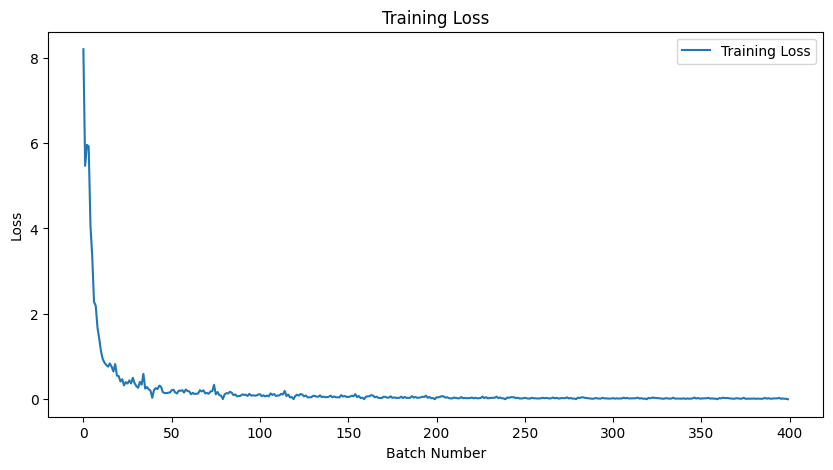

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'losses' contains the loss of each batch
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Acurracy Test After Training (20 pts)

In [ ]:
le5_model.eval()  # Set the model to evaluation mode


accuracy = networks.cal_accuracy(le5_model, DataLoader(train_set, batch_size=num_of_training_samples, shuffle=False), device)
print(f'Accuracy of the model on the training images: {accuracy*100:.2f}%')
assert accuracy > 0.99

accuracy = networks.cal_accuracy(le5_model, DataLoader(testing_set, batch_size=num_of_testing_samples, shuffle=False), device)
print(f'Accuracy of the model on the testing images: {accuracy*100:.2f}%')
assert accuracy > 0.97

Accuracy of the model on the training images: 99.79%
Accuracy of the model on the testing images: 97.30%


# ResNet-18 (30 pts)

You are required to implement ResNet-18 in `networks.py`. Refer to the lecture slides or source code for insights on the network's architecture. You really want to use GPU for your training.

### Acurracy Test Before Training (5 pts)

In [ ]:
import torch
torch.cuda.empty_cache()

resnet_18 = networks.ResNet18().to(device)

resnet_18.apply(networks.kaiming_init)

resnet_18.eval()  # Set the model to evaluation mode


accuracy = networks.cal_accuracy(resnet_18, DataLoader(train_set, batch_size=num_of_training_samples, shuffle=False), device)
print(f'Accuracy of the model on the training images: {accuracy*100:.2f}%')
assert accuracy < 0.5

accuracy = networks.cal_accuracy(resnet_18, DataLoader(testing_set, batch_size=num_of_testing_samples, shuffle=False), device)
print(f'Accuracy of the model on the testing images: {accuracy*100:.2f}%')
assert accuracy < 0.5

Accuracy of the model on the training images: 11.76%
Accuracy of the model on the testing images: 12.80%


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

train_loader = DataLoader(train_set, batch_size=256, shuffle=False)

# Optimizer
optimizer = optim.Adam(resnet_18.parameters(), lr=0.001)

total_epochs = 20

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=0.00001)  # eta_min is the minimum lr


# Loss function
criterion = nn.CrossEntropyLoss()

# Training loop
resnet_18.train()
losses = []
for epoch in range(total_epochs):  # Let's do one epoch for simplicity
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = resnet_18(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"{epoch=}, {losses[-1]=}")
    # Step the scheduler after each epoch
    scheduler.step()

epoch=0, losses[-1]=0.004139740951359272
epoch=1, losses[-1]=0.0009875595569610596
epoch=2, losses[-1]=0.021612610667943954
epoch=3, losses[-1]=2.1024610759923235e-05
epoch=4, losses[-1]=0.00021115968411322683
epoch=5, losses[-1]=0.002301438245922327
epoch=6, losses[-1]=2.980717908940278e-05
epoch=7, losses[-1]=2.1367428416851908e-05
epoch=8, losses[-1]=9.506720743956976e-06
epoch=9, losses[-1]=1.3142380339559168e-05
epoch=10, losses[-1]=1.1413965694373474e-05
epoch=11, losses[-1]=9.886690349958371e-06
epoch=12, losses[-1]=9.16401950235013e-06
epoch=13, losses[-1]=8.694652933627367e-06
epoch=14, losses[-1]=8.381741281482391e-06
epoch=15, losses[-1]=8.143331797327846e-06
epoch=16, losses[-1]=8.024127964745276e-06
epoch=17, losses[-1]=7.927274054964073e-06
epoch=18, losses[-1]=7.87512180977501e-06
epoch=19, losses[-1]=7.83042014518287e-06


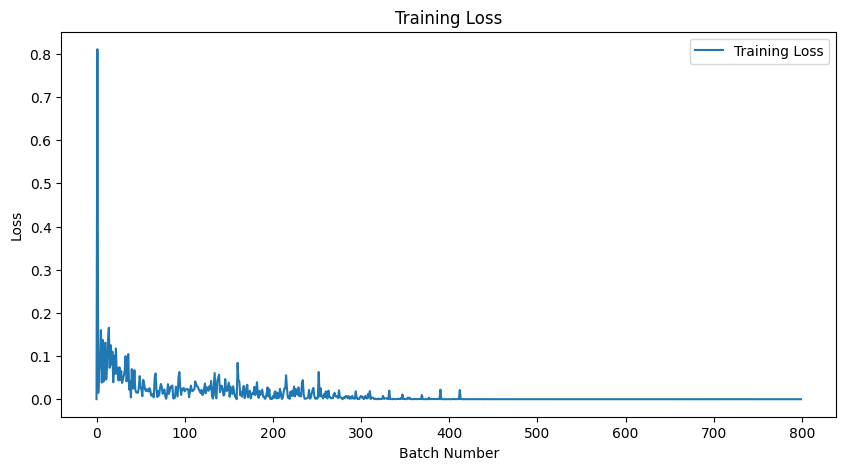

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'losses' contains the loss of each batch
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Acurracy Test After Training (25 pts)

In [ ]:
resnet_18.eval()  # Set the model to evaluation mode

accuracy = networks.cal_accuracy(resnet_18, DataLoader(train_set, batch_size=num_of_training_samples, shuffle=False), device)
print(f'Accuracy of the model on the training images: {accuracy*100:.2f}%')
assert accuracy > 0.99

accuracy = networks.cal_accuracy(resnet_18, DataLoader(testing_set, batch_size=num_of_testing_samples, shuffle=False), device)
print(f'Accuracy of the model on the testing images: {accuracy*100:.2f}%')
assert accuracy > 0.98

Accuracy of the model on the training images: 100.00%
Accuracy of the model on the testing images: 98.20%
